# Стартап продажи продуктов питания

**Описание проекта**

Есть стартап, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи мобильного приложения.

**План работы:**

- Изучим воронку продаж;
- Узнаем, как пользователи доходят до покупки;
- Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуем результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясним, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

**Описание данных**

Каждая запись в логе — это действие пользователя, или событие. 
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

### 1. Откроем файл с данными и изучим общую информацию

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import math as mth
import warnings
from scipy import stats as st
warnings.filterwarnings('ignore')

In [2]:
# Загрузим данные из датафрейма
data=pd.read_csv('/datasets/logs_exp.csv', sep='\t') 

In [3]:
# Изучим исходный датафрейм, выведем первые 10 строчек
data.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [4]:
# Изучим исходную информацию датафрейма
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### 2. Предобработка данных

#### 2.1 Заменим названия столбцов 

In [5]:
# Переименуем названия столбцов для более удобного использования их названий
data.rename(columns = {'EventName':'event_name', 
                       'DeviceIDHash':'user_id', 
                       'EventTimestamp':'event_time',
                       'ExpId':'group'}, inplace = True)

In [6]:
# Создадим функцию new_mean_group() для более наглядного вывода значений столбца group
def new_mean_group (group):
    if group == 246:
        return 'A1'
    if group == 247:
        return 'A2'
    if group == 248:
        return 'B'
    return 'Без группы'  

In [7]:
# Заменим значения в столбце group
data ['group'] = data ['group'].apply(new_mean_group)

In [8]:
# Проверим содержимое измененного столбца group
data['group'].unique()

array(['A1', 'B', 'A2'], dtype=object)

Все отлично, замена значений столбца group прошла успешно.

#### 2.2 Проверим пропуски и типы данных

In [9]:
# Определим в каких столбцах есть пропуски
data.isna().sum()

event_name    0
user_id       0
event_time    0
group         0
dtype: int64

Пропуски в столбцах **отсутствуют**.

In [10]:
# Cкорректируем тип данных столбца event_time
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')

In [11]:
# Посчитаем количество дубликатов
print ('Количество дубликатов:', data.duplicated().sum())

Количество дубликатов: 413


In [12]:
# Попробуем рассмотреть поподробнее, где встречаются дубликаты
data[data.duplicated()].sort_values(by=['event_time']).head(20)

,event_name,user_id,event_time,group
453,MainScreenAppear,5613408041324010552,2019-07-30 08:19:44,B
2350,CartScreenAppear,1694940645335807244,2019-07-31 21:51:39,B
3573,MainScreenAppear,434103746454591587,2019-08-01 02:59:37,B
4076,MainScreenAppear,3761373764179762633,2019-08-01 03:47:46,A2
4803,MainScreenAppear,2835328739789306622,2019-08-01 04:44:01,B
5641,CartScreenAppear,4248762472840564256,2019-08-01 05:36:04,B
5875,PaymentScreenSuccessful,6427012997733591237,2019-08-01 05:47:32,B
7249,OffersScreenAppear,7224691986599895551,2019-08-01 06:44:06,A1
8065,CartScreenAppear,8189122927585332969,2019-08-01 07:18:49,B
9179,MainScreenAppear,2230705996155527339,2019-08-01 07:54:47,A1


In [13]:
# Рассмотрим конкретный выделяющийся случай
data[(data['user_id'] == 3528217211962170139) & (data['event_time'] == '2019-08-01 11:13:23')]

,event_name,user_id,event_time,group
15750,PaymentScreenSuccessful,3528217211962170139,2019-08-01 11:13:23,A2
15751,PaymentScreenSuccessful,3528217211962170139,2019-08-01 11:13:23,A2
15752,PaymentScreenSuccessful,3528217211962170139,2019-08-01 11:13:23,A2
15753,PaymentScreenSuccessful,3528217211962170139,2019-08-01 11:13:23,A2


Видим, что запись повторяется 4 раза, следовательно таких дубликтов может быть и 2, и 3, значит можем удалить их.

In [14]:
# Удалим явные дубликаты
data = data.drop_duplicates().reset_index(drop=True)

In [15]:
# Посмотрим на количество пользователей в каждой группе
data['group'].value_counts().to_frame()

,group
B,85582
A1,80181
A2,77950


#### 2.3 Добавим отдельный столбец дат

In [16]:
# Добаим новый столбец с датой
data['date'] = data['event_time'].dt.date

In [17]:
# Cкорректируем тип данных столбца date
data['date'] = pd.to_datetime(data['date'])

In [18]:
# Посмотрим на итоговые 10 строк датафрейма после предобработки данных
data.head(10)

,event_name,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25
5,CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,B,2019-07-25
6,OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,A1,2019-07-25
7,MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,A1,2019-07-25
8,MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,A2,2019-07-25
9,MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,A1,2019-07-26


In [19]:
# Посмотрим на исходную информацию датафрейма после предобработки данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  object        
 4   date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(2)
memory usage: 9.3+ MB


### 3. Изучим и проверим данные

#### 3.1 Сколько всего событий в логе

In [20]:
event_all = data['event_name'].value_counts()

Всего **5 уникальных событий** в логе: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial.            

In [21]:
total_event_name = data['event_name'].count()
print ('Общее количество событий в логе:', total_event_name)

Общее количество событий в логе: 243713


#### 3.2 Сколько всего пользователей в логе

In [22]:
unique_user_id = data['user_id'].nunique()
print ('Уникальных пользователей в логе:', unique_user_id)

Уникальных пользователей в логе: 7551


#### 3.3 Сколько в среднем событий приходится на пользователя

In [23]:
mean_event_name_on_user = data.groupby('user_id')['event_name'].count().median() 
# т.к. есть выбросы, используем медианное значение, а не среднее
print ('Среднее количество событий на пользователя:', mean_event_name_on_user)

Среднее количество событий на пользователя: 20.0


#### 3.4 Определим данными за какой период мы располагаем

In [24]:
# Определим минимальную дату привлечения пользователей
min_analysis_date = data['event_time'].min()
print('Минимальная дата привлечения пользователей:', min_analysis_date)

Минимальная дата привлечения пользователей: 2019-07-25 04:43:36


In [25]:
# Определим максимальную дату привлечения пользователей
max_analysis_date = data['event_time'].max()
print('Максимальная дата привлечения пользователей:', max_analysis_date)

Максимальная дата привлечения пользователей: 2019-08-07 21:15:17


У нас есть данные за **14 дней**.

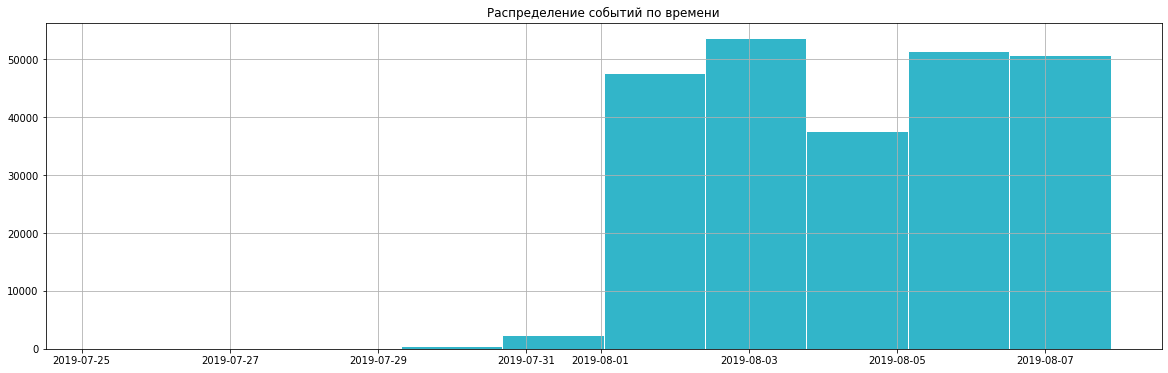

In [26]:
data['event_time'].hist(figsize=(20,6), 
                        color="#32B5C9", 
                        ec="white", 
                        grid=True).set_title('Распределение событий по времени');

Глядя на гистограмму распределения событий по времени, видим, что у нас одинаково **полные данные только за период с         2019-08-01 по 2019-08-07**. До 1 августа данные не полные, следовательно события за июль можно отбросить.

In [27]:
# Отбросим данные за июль
data = data.query('event_time > "2019-08-01"').reset_index(drop=True)

In [28]:
# Проверим данные за какой период у нас остались
data['event_time'].sort_values().to_frame()

,event_time
0,2019-08-01 00:07:28
1,2019-08-01 00:08:00
2,2019-08-01 00:08:55
3,2019-08-01 00:08:58
4,2019-08-01 00:08:59
...,...
240882,2019-08-07 21:12:25
240883,2019-08-07 21:13:59
240884,2019-08-07 21:14:43
240885,2019-08-07 21:14:58


#### 3.5 Количество событий и пользователей, которое мы потеряли отбросив старые данные

In [29]:
new_total_event_name = data['event_name'].count()
print ('Общее количество событий в логе, после фильтрации данных:', new_total_event_name)

Общее количество событий в логе, после фильтрации данных: 240887


In [30]:
t1 = total_event_name
t2 = new_total_event_name 
print(f'Количество потерянных пользователей - {t1-t2}, что сотавляет {round((t1-t2)/t1*100,2)}% от первоначального количества.')

Количество потерянных пользователей - 2826, что сотавляет 1.16% от первоначального количества.


In [31]:
new_unique_user_id = data['user_id'].nunique()
print ('Общее количество уникальных пользователей в логе, после фильтрации данных:', new_unique_user_id)

Общее количество уникальных пользователей в логе, после фильтрации данных: 7534


In [32]:
s1 = unique_user_id
s2 = new_unique_user_id
print(f'Количество потерянных событий - {s1-s2}, что сотавляет {round((s1-s2)/s1*100,2)}% от первоначального количества.')

Количество потерянных событий - 17, что сотавляет 0.23% от первоначального количества.


#### 3.6 Проверим, что у нас есть пользователи из всех трёх экспериментальных групп

In [33]:
data.groupby('group')['user_id'].nunique().to_frame()

,user_id
group,
A1,2484
A2,2513
B,2537


Пользователей примерно по **2500 в каждой группе**.

### 4. Изучим воронку событий

#### 4.1 Посмотрим, какие события есть в логах, как часто они встречаются. Отсортируем события по частоте

In [34]:
# Посмотрим какие события есть в логах и как часто они встречаются
data.event_name.value_counts().to_frame()

,event_name
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


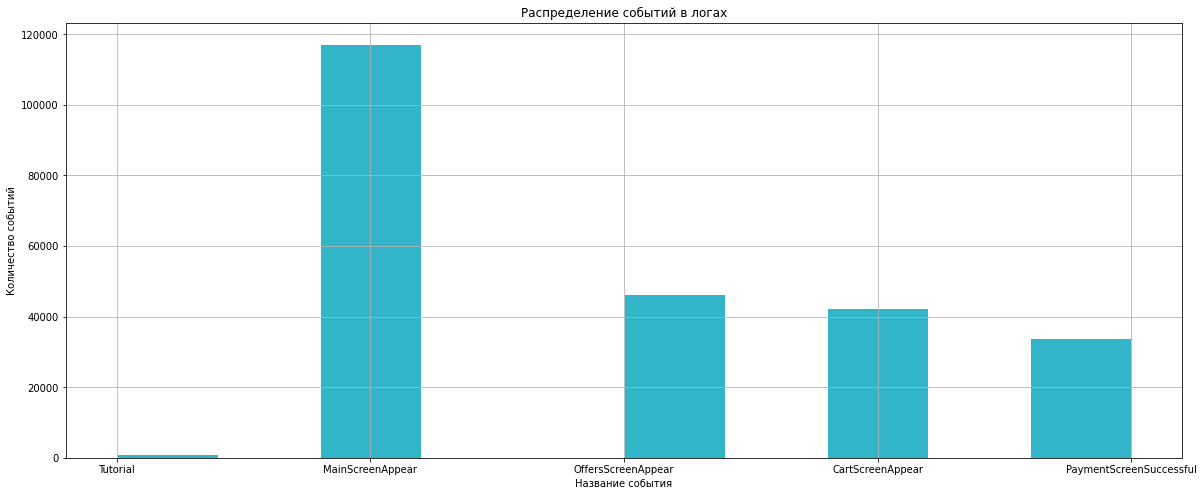

In [35]:
# Отобразим результат графически
data['event_name'].hist(figsize=(20,8), 
                        color="#32B5C9", 
                        ec="white", 
                        grid=True).set_title('Распределение событий в логах')
plt.xlabel('Название события')
plt.ylabel('Количество событий');

Мы видим что событие **MainScreenAppear (появление основного экрана)** наиболее часто встречающееся, оно случалось 117 328 раз, затем идет **OffersScreenAppear (появление экрана предложений)** - 46 333 раза, дальше по популярности следует событие **CartScreenAppear (появление экрана корзины)**, оно случалось 42 303 раза, потом **PaymentScreenSuccessful (экран платеж успешен)** - 33 918 раз, и завершает всё событие **Tutorial (руководство пользователя)**, оно случилось 1 005 раз. 

#### 4.2 Посчитаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие

In [36]:
# Выведем количество событий и сколько пользователей совершали каждое из этих событий
event_users = data.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
# Посчитаем долю пользователей, которые хоть раз совершали событие
event_users['event_commit_share'] = (event_users['user_id'] / new_unique_user_id * 100).round(2)

In [37]:
event_users = event_users.reset_index(drop=True)
event_users

,event_name,user_id,event_commit_share
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


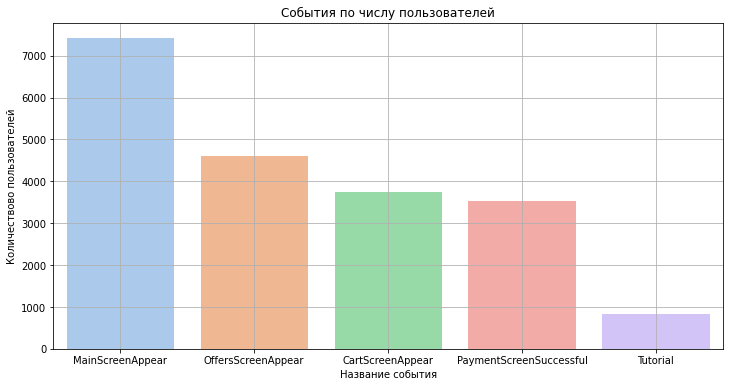

In [38]:
# Отобразим результат графически
plt.figure(figsize=(12,6))
# plt.bar(x=events_users['event'], height=events_users["part_event"], width=0.7, color='green')
sns.barplot(y='user_id', x='event_name', data=event_users, palette='pastel')
plt.xlabel('Название события')
plt.grid()
plt.ylabel('Количествово пользователей')
plt.title('События по числу пользователей')
plt.show();

Мы видим что событие **MainScreenAppear (появление основного экрана)** среди пользователей проявляется чаще всего - 7 419 человек, затем идет **OffersScreenAppear (появление экрана предложений)** - 4 593 человека, дальше по популярности следует событие **CartScreenAppear (появление экрана корзины)**, до него долши 3 734 пользователя, потом **PaymentScreenSuccessful (экран платеж успешен)** - 3 539 человека, и завершает всё событие **Tutorial (руководство пользователя)**, его совершили 840 человек. 

#### 4.3 Предположим, в каком порядке происходят события

Предположу, что события располагаются в следующем порядке:
- 1. MainScreenAppear - пользователь зашел в приложение;
- 2. OffersScreenAppear - пользователь открыл каталог товаров;
- 3. CartScreenAppear - пользователь добавил товар в корзину;
- 4. PaymentScreenSuccessful - пользователь оплатил товар;
 
 
 Tutorial - руководство пользователя, выбивается из логической цепочки.

#### 4.4 По воронке событий посчитаем, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)

In [39]:
# Исключим событие Tutorial из расчета воронки
event_users = event_users.query('event_name != "Tutorial"')

previous_users = event_users.loc[0,'user_id']
for i in event_users.index:
    event_users.loc[i,'share_from_previous_users'] = (event_users.loc[i,'user_id'] / previous_users * 100).round(2)
    previous_users = event_users.loc[i,'user_id']

event_users  

,event_name,user_id,event_commit_share,share_from_previous_users
0,MainScreenAppear,7419,98.47,100.00
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78


Из таблицы видно, что почти 62% пользователей с главного меню приложения перешли в каталог товаров, далее доля тех, кто оказался в меню каталога товаров и добавил товар в корзину составина 81.3%, и практичеки 95% из тех, кто оказался в меню с корзиной оплатили товар. 

#### 4.5 Шаг, на котором мы теряем больше всего пользователей


Из таблицы выше видно, что больше всего пользователей - 38%, потеряно при переходе с главной страницы в каталог товаров. Возможно, есть что-то, что мешает, отпугивает пользователей на первом экране (MainScreenAppear).

#### 4.6 Доля пользователей, которая доходит от первого события до оплаты

In [41]:
start_users = event_users.loc[0,'user_id']
for i in event_users.index:
    event_users.loc[i,'share_from_start_users'] = (event_users.loc[i,'user_id'] / start_users * 100).round(2)

event_users

,event_name,user_id,event_commit_share,share_from_previous_users,share_from_start_users
0,MainScreenAppear,7419,98.47,100.00,100.00
1,OffersScreenAppear,4593,60.96,61.91,61.91
2,CartScreenAppear,3734,49.56,81.30,50.33
3,PaymentScreenSuccessful,3539,46.97,94.78,47.70


Из таблицы видно, что от события **MainScreenAppear** до события **PaymentScreenSuccessful** дошло почти 48% пользователей.

### 5. Изучим результаты эксперимента

#### 5.1 Сколько пользователей в каждой экспериментальной группе

In [43]:
data_groups = data.groupby('group')['user_id'].nunique()
data_groups['A1+A2'] = data_groups['A1'] + data_groups['A2']
data_groups.to_frame()

,user_id
group,
A1,2484
A2,2513
B,2537
A1+A2,4997


Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами (А1 и А2) и одну экспериментальную — с новыми (В).

В группе А1 - 2 484 пользователя.

В группе А2 - 2 513 пользователей.

В группе В - 2 537 пользователей.

В группе А1+А2 - 4 997 пользователей.

In [44]:
# Проверим корректность разделения пользователей по группам
group_a1 = data[data['group'] == 'A1']['user_id']
group_a2 = data[data['group'] == 'A2']['user_id']
group_b = data[data['group'] == 'B']['user_id']
both_group = data.query('user_id in @group_a1 and user_id in @group_a2 and user_id in@group_b')
display(both_group['user_id'].unique())
print('Количество одинаковых пользователей в трех группах:', both_group['user_id'].nunique())
print('Всего пользователей в тесте:', data['user_id'].nunique())

array([], dtype=int64)

Количество одинаковых пользователей в трех группах: 0
Всего пользователей в тесте: 7534


Пользователи между собой в группах не пересекались.

#### 5.2 А1/А2/B - тесты

In [46]:
# Сделам таблицу с числом уникальных пользователей по событиям и контрольным группам
data_funnel = data.pivot_table(index='group',columns = 'event_name', values='user_id',aggfunc='nunique')
del data_funnel['Tutorial']
data_funnel

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
group,,,,
A1,1266,2450,1542,1200
A2,1238,2476,1520,1158
B,1230,2493,1531,1181


Разбиение на группы довольно равномерно, его можно считать корректным.

In [47]:
# Для проведения тестов составим таблицу event_group_test, где указано число пользователей в воронке, 
# идущей по событиям и по всем группам
event_group_test = data.query('event_name != "Tutorial"').pivot_table(
    index='event_name', 
    columns='group', 
    values='user_id',
    aggfunc='nunique').sort_values(by='A1', ascending=False)

event_group_test = event_group_test.reset_index()
event_group_test['A1+A2'] = event_group_test['A1'] + event_group_test['A2']
event_group_test['total'] = event_group_test['A1+A2'] + event_group_test['B']

event_group_test['step_A1'] = (event_group_test['A1'] / data_groups['A1'] * 100).round(2)
event_group_test['step_A2'] = (event_group_test['A2'] / data_groups['A2'] * 100).round(2)
event_group_test['step_B'] = (event_group_test['B'] / data_groups['B'] * 100).round(2)
event_group_test['step_A1+A2'] = ((event_group_test['A1'] + event_group_test['A2']) / 
                                  (data_groups['A1'] + data_groups['A2']) * 100).round(2)

event_group_test

group,event_name,A1,A2,B,A1+A2,total,step_A1,step_A2,step_B,step_A1+A2
0,MainScreenAppear,2450,2476,2493,4926,7419,98.63,98.53,98.27,98.58
1,OffersScreenAppear,1542,1520,1531,3062,4593,62.08,60.49,60.35,61.28
2,CartScreenAppear,1266,1238,1230,2504,3734,50.97,49.26,48.48,50.11
3,PaymentScreenSuccessful,1200,1158,1181,2358,3539,48.31,46.08,46.55,47.19


Самым популярным событием является **MainScreenAppear - появление главного экрана в приложении**, его совершило 7 419 пользователей.

В разрезе групп это выглядит так:
- А1 - 2 450 пользователей;
- А2 - 2 476 пользователей;
- В - 2 493 пользователя.

Доля пользователей, совершививших самое популярное событие:

- А1 - 98.6%;
- A2 - 98.5%;
- B - 98.3%.

##### 5.2.1 A1/A2 - тест

**Сформулируем гипотезы. Нулевая гипотеза: доли в двух выборках равны. Альтернативная гипотеза: доли в двух выборках не равны.** 

Уровень статистической значимости примем равным 1%, т.к. группы А1 и А2 должны быть одинаковыми, то и контроль строже.

In [48]:
# Напишем функцию z_test для проведения тестов, на вход подаются 3 параметра:
# наименование первой группы, наименование второй группы, alpha - уровень статистической значимости:
def z_test (group1, group2, alpha):
    for i in event_group_test.index:
        p1 = event_group_test[group1][i] / data_groups[group1]
        # пропорция успехов во второй группе:
        p2 = event_group_test[group2][i] / data_groups[group2]
        # пропорция успехов в комбинированном датасете:
        p_combined = ((event_group_test[group1][i] + event_group_test[group2][i]) / 
                      (data_groups[group1] + data_groups[group2]))
        # разница пропорций в датасетах
        difference = p1 - p2
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * 
                                        (1/data_groups[group1] + 1/data_groups[group2]))
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 
        
        p_value = (1 - distr.cdf(abs(z_value))) * 2
        print('{} p-значение: {}'.format(event_group_test['event_name'][i], p_value))
        if (p_value < alpha):
            print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
        else:
            print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")
        print('')
        
z_test("A1", "A2", 0.01)

MainScreenAppear p-значение: 0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**По результатам A1/A2 тестирования для всех событий разница не оказалось значимой, следовательно эти группы можем считать контрольными.**

Так как для A/B теста не нужна высокая точность, то для дальнейших экспериментов примем уровень значимости равный 5%.

##### 5.2.2 A1/B - тест

In [49]:
z_test("A1", "B", 0.05)

MainScreenAppear p-значение: 0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Значимой разницы между контрольной группой А1 и экспериментальной группой В не выявлено.**

##### 5.2.3 A2/B - тест

In [50]:
z_test("A2", "B", 0.05)

MainScreenAppear p-значение: 0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Значимой разницы между контрольной группой А2 и экспериментальной группой В не выявлено.**

##### 5.2.4 A1/A2/B - тест

In [51]:
z_test("A1+A2", "B", 0.05)

MainScreenAppear p-значение: 0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear p-значение: 0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear p-значение: 0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful p-значение: 0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



**Значимой разницы между контрольной группой А1/A2 и экспериментальной группой В не выявлено.**

### 6. Вывод

В ходе анализа данного проекта была составлена воронка событий, как пользователи доходят до покупки: MainScreenAppear - пользователь зашел в приложение, OffersScreenAppear - пользователь открыл каталог товаров, CartScreenAppear - пользователь добавил товар в корзину, PaymentScreenSuccessful - пользователь оплатил товар.

Событие Tutorial - руководство пользователя, не несет полезной нагрузки, поэтому его не стали принимать во внимание.

При исследовании воронки событий было выявлено, что 7 419 пользователей (98.5% от всех) хотя бы раз открывали главную страницу приложения.
4 593 пользователей хотя бы раз открывали страницу с каталогом товаров, 3 734 пользователя перешли в корзину, и 3 539 пользователя оплатили товар.

Больше всего пользователей - 38%, потеряно при переходе с главной страницы в каталог товаров. Возможно, есть что-то, что мешает, отпугивает пользователей на главной странице.

От первого события на главной странице приложения до оплаты доходит чуть меньше половины пользователей - 48%.

В ходе А/A/B тестирования было проведено 16 проверок статистических гипотез, в результате которых не было выявлено значимой разницы между тестируемыми группами, поэтому можно утверждать, что изменние шрифта на поведение пользователей значимого эффекта не оказало.